In [1]:
system("apt-get install -y jags")
install.packages("rjags")
install.packages("coda")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("reshape2") # Install the package to fix the error.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [3]:
### Variable selection illustration in Section 5.2


# Predictive resampling with penalty and "blockstrapping"
resample <- function(X, Y, method, blocks){
  data.trial <- data.frame(cbind(Y, X))
  X = data.frame(X)
  for(block in 1:blocks){
    model.low = lm(Y~1, data=data.trial)
    if(method == "AIC") {pen=2} else {pen=log(nrow(data.trial))}
    model.step = stepAIC(model.low, direction="forward", k=pen, trace=FALSE,
                         scope=list(lower=model.low, upper=lm(Y~., data=data.trial)))
    Y.pred = predict(model.step, X, se=T)
    if(sum(is.na(Y.pred$se.fit)) > 0){
      Y.new = Y.pred$fit
    } else {
      Y.new = rnorm(length(Y), Y.pred$fit, Y.pred$se.fit)
    }
    data.imp = cbind(Y.new, X)
    colnames(data.imp)[1] = "Y"
    data.trial = rbind(data.trial, data.imp)
  }
  model.vars <- names(coef(model.step))
  model.vars <- gsub("X", "", model.vars[grep("X", model.vars)])
  print(method)
  return(as.numeric(model.vars))
}


# Define JAGS model as a string
model_string <- "
model {
  for (i in 1:N) {
    y[i] ~ dnorm(mu[i], tau)
    mu[i] <- beta0 + sum(beta[1:K] * X[i, 1:K] * gamma[1:K])
  }

  beta0 ~ dnorm(0, 0.01)
  tau ~ dgamma(0.01, 0.01)
  sigma <- 1 / sqrt(tau)

  for (j in 1:K) {
    gamma[j] ~ dbern(0.5)
    beta[j] ~ dnorm(0, 0.01)
  }
}
"

# Gibbs sampling approximation of RJ-MCMC
jump <- function(X, Y){
  jags.data <- list("N" = length(Y), "K" = k, "X" = X, "y" = Y)
  # model.path = "gibbs.jags" # specify correctly
  init.values <- function() {
    list(
      beta0 = rnorm(1), # intercept parameter
      beta = rnorm(k), # individual coefficients
      tau = max(rgamma(1, 0.01, 0.01), 1e-200), # noise variance
      gamma = rbinom(k, 1, 0.5) # inclusion of coefficient
    )
  }
  parameters <- c("beta", "gamma")

  model <- jags.model(file = textConnection(model_string), data = jags.data,
                      inits = init.values, n.chains = 3, n.adapt = 1000)
  update(model, 5000) # burn-in period
  samples <- coda.samples(model, variable.names = parameters, n.iter = 10000, thin = 10)
  samples.matrix <- as.matrix(samples)
  gamma.samples <- samples.matrix[, grep("^gamma", colnames(samples.matrix))]
  return(colMeans(gamma.samples))
}




# Test with true X data (without measurement error)

In [4]:
### Variable selection illustration in Section 5.2

library(MASS)
library(ggplot2)
library(reshape2)
library(dplyr)
library(rjags)
library(scales)

n.tests = c(20, 100)
k = 20
trials = 2
blocks = 10

sel.bic = matrix(0, nrow=length(n.tests), ncol=k)
rownames(sel.bic) = n.tests
colnames(sel.bic) = paste("X", 1:k, sep="")
sel.aic = sel.bic
sel.rjm = array(0, dim=c(length(n.tests), k, trials))

sigma_X <- 0.5  # Adjust this value as needed

# Direct comparison of methods with regenerated data
for(trial in 1:trials){
  print(trial)
  print(Sys.time())
  for(i in seq_along(n.tests)){
    n.test = n.tests[i]

    # Generate the true predictor data
    true_X <- matrix(rnorm(n.test * k), ncol = k)
    colnames(true_X) <- paste("X", 1:k, sep="")

    Xobs <- true_X

    colnames(Xobs) <- colnames(sel.bic)
    beta <- c(rep(1, 5), rep(0, 15))
    Y <- as.numeric(Xobs %*% beta + rnorm(n.test))

    vars.bic = resample(Xobs, Y, "BIC", blocks)
    sel.bic[i, vars.bic] <- sel.bic[i, vars.bic] + 1
    vars.aic = resample(Xobs, Y, "AIC", blocks)
    sel.aic[i, vars.aic] <- sel.aic[i, vars.aic] + 1
    weights.rjm = jump(Xobs, Y)
    sel.rjm[i,,trial] <- weights.rjm
  }
}



Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



[1] 1
[1] "2025-03-06 18:11:30 UTC"
[1] "BIC"
[1] "AIC"
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 42
   Total graph size: 552

Initializing model

[1] "BIC"
[1] "AIC"
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 42
   Total graph size: 2552

Initializing model

[1] 2
[1] "2025-03-06 18:15:16 UTC"
[1] "BIC"
[1] "AIC"
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 42
   Total graph size: 552

Initializing model

[1] "BIC"
[1] "AIC"
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 42
   Total graph size: 2552

Initializing model



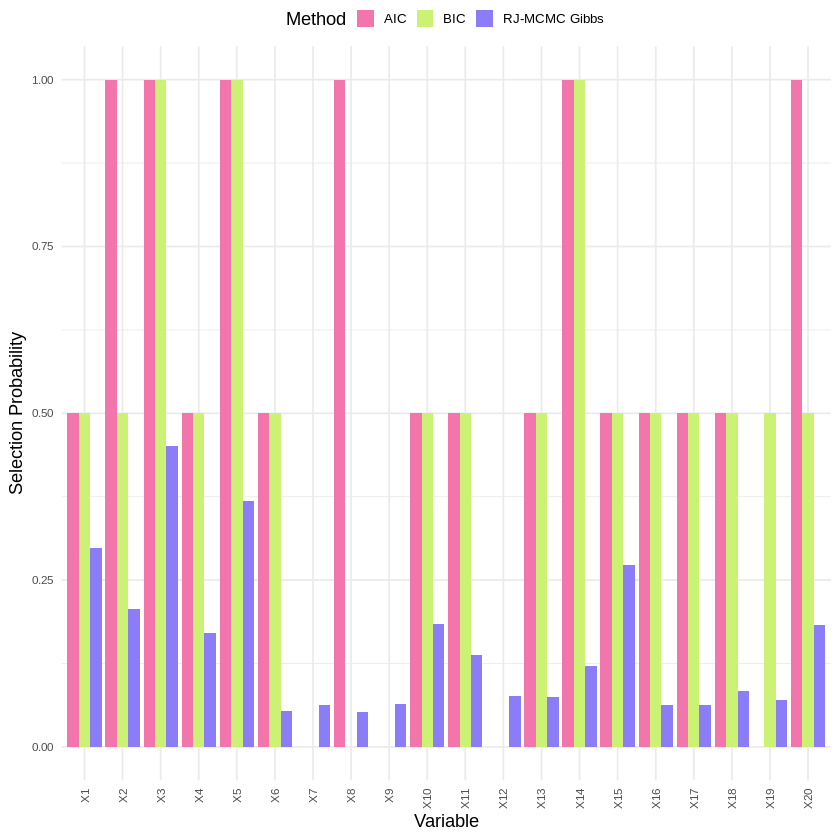

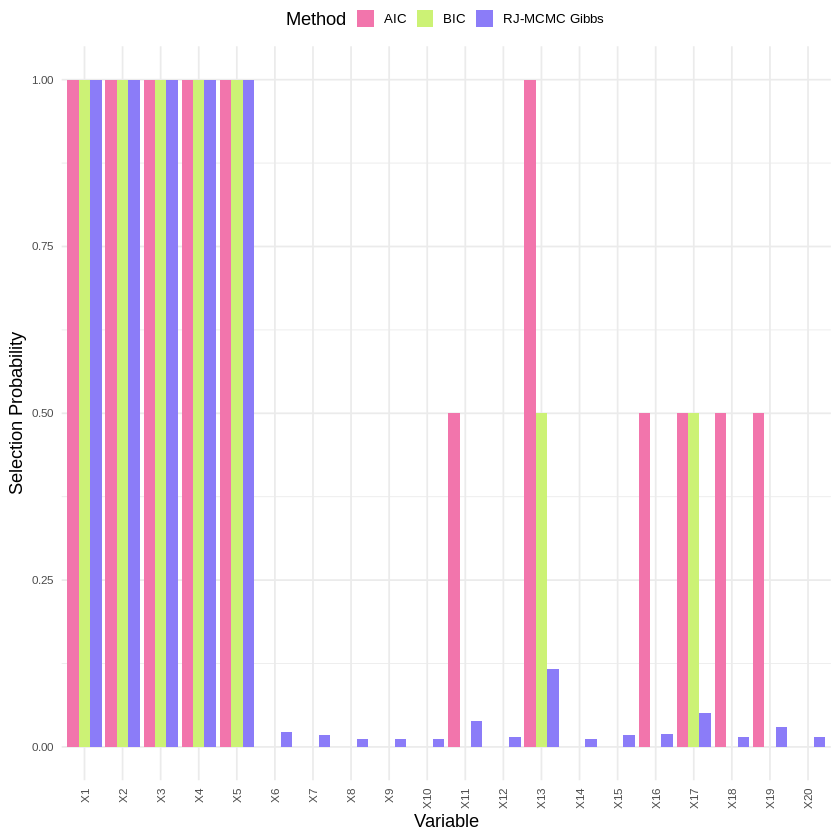

In [6]:
# Load necessary libraries
library(ggplot2)
library(reshape2)

# Normalize selection frequencies
sel.bic2 = sel.bic / trials
sel.aic2 = sel.aic / trials
sel.rj12 = apply(sel.rjm, c(1, 2), function(x) mean(x))  # Average Gibbs selection probability

# Convert matrices to data frames and add 'n' as a column
df_bic <- data.frame(n = c(20, 100), sel.bic2)
df_aic <- data.frame(n = c(20, 100), sel.aic2)
df_rj1 <- data.frame(n = c(20, 100), sel.rj12)  # Gibbs selection probabilities

# Convert to long format with correct ID variable
bic_long <- melt(df_bic, id.vars = "n", variable.name = "Variable", value.name = "Selection_Probability")
aic_long <- melt(df_aic, id.vars = "n", variable.name = "Variable", value.name = "Selection_Probability")
rjmcmc_long <- melt(df_rj1, id.vars = "n", variable.name = "Variable", value.name = "Selection_Probability")

# Add method labels
bic_long$Method <- "BIC"
aic_long$Method <- "AIC"
rjmcmc_long$Method <- "RJ-MCMC Gibbs"

# Combine all methods into one dataset
all_data <- rbind(bic_long, aic_long, rjmcmc_long)

# Convert `n` to factor
all_data$n <- factor(all_data$n, levels = c("20", "100"))

# Function to generate and save separate plots for each n
plot_and_save <- function(n_value, file_name) {
  plot_data <- subset(all_data, n == n_value)

  plot <- ggplot(plot_data, aes(x = Variable, y = Selection_Probability, fill = Method)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    theme_minimal() +
    labs(y = "Selection Probability", x = "Variable") +  # No title
    scale_fill_manual(values = c("BIC" = "#CCF275", "AIC" = "#F275AC", "RJ-MCMC Gibbs" = "#8B7CF8")) +  # Neutral colors
    theme(
      axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 7),  # Smaller x-axis labels
      axis.text.y = element_text(size = 7),  # Smaller y-axis labels
      legend.position = "top",  # Legend on top to save space
      legend.text = element_text(size = 8),  # Smaller legend text
      legend.key.size = unit(0.4, "cm"),  # Smaller legend squares
      legend.margin = margin(0, 0, 0, 0)  # Reduce legend padding
    )

  # Print the plot to ensure it's rendered
  print(plot)

  # Save the plot with improved size
  ggsave(file_name, plot = plot, width = 15, height = 6, units = "cm", dpi = 300)
}

# Generate and save separate plots
plot_and_save(20, "variable_selection_n20.png")
plot_and_save(100, "variable_selection_n100.png")
